# Zebra Page Separation A/B Test Analysis Report 5: 
# Scrolling to top behavior
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969) [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Curiosity Question3: Does it impact the scrolling to top behavior? (Nice to have)


In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [3]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Import data

In [7]:
df_pageviews <- read.csv("Data/pageviews_20230710.csv")

In [8]:
dim(df_pageviews)

[1] 19921367        6

In [10]:
query_scroll <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE  t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_anon
AND NOT is_bot
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.web_session_id AS session_id, 
wiki,  t4.test_group,   t3.page_id,  count(1) AS scrolls
FROM event.mediawiki_web_ui_scroll AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.web_session_id = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND t3.action='scroll-to-top'
AND t3.skin='vector-2022'
-- exclude anonymous users, some sessions swtich between loggin mode and loggout mode.
AND NOT t3.is_anon
-- exclude bots
AND NOT t3.is_bot
GROUP BY t3.web_session_id, t3.wiki,  t4.test_group, t3.page_id
"

In [11]:
df_scroll <- wmfdata::query_hive(query_scroll)

Don't forget to authenticate with Kerberos using kinit



In [14]:
#df_scroll <-  read.csv('Data/scroll_20230622.csv')

In [13]:
df_pvs_per_session <- df_pageviews %>%
  group_by(session_id,wiki, test_group,editcountbucket) %>%
  summarize(n_pvs=sum(pvs), n_pvs_page_token=n_distinct(page_token), .groups='drop')

In [30]:
df_pvs_bucket <- df_pvs_per_session %>% 
  mutate(
          editcountbucket_n = 
            case_when(
                editcountbucket == '0 edits' ~ 0 ,
                editcountbucket == '1-4 edits' ~ 4,
                editcountbucket == '5-99 edits' ~ 99,
                editcountbucket == '100-999 edits'  ~ 999,
                editcountbucket == '1000+ edits' ~ 1000,
                TRUE ~ NA
            )
        ) %>%
   group_by(session_id, wiki, test_group ) %>%
   summarize(sum_pvs=sum(n_pvs), sum_pv_pages=sum(n_pvs_page_token),
             editcountbucket_begin=min(editcountbucket_n),
             editcountbucket_end=max(editcountbucket_n),
             .groups='drop')

In [32]:
df_pvs_bucket <- df_pvs_bucket  %>%
     mutate(
          editcountbucket_lab = factor(
            case_when(
                editcountbucket_begin == 0 ~ '0_edits'  ,
                editcountbucket_begin == 4 ~ '1_4_edits' ,
                editcountbucket_begin == 99 ~ '5_99_edits' ,
                editcountbucket_begin == 999 ~ '100_999_edits'  ,
                editcountbucket_begin == 1000 ~ '1000_more_edits',
                TRUE ~ 'others'
            ), levels = c('0_edits', '1_4_edits' ,'5_99_edits', '100_999_edits', '1000_more_edits', 'other')
          ) 
         )

In [34]:

df_pvs_bucket_per_session <- df_pvs_bucket %>%
   group_by(session_id, wiki, test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages),
             .groups='drop') 

In [35]:
dim(df_pvs_bucket_per_session )

[1] 1106811       6

In [21]:
df_scroll_per_session <-  df_scroll %>%
  group_by(session_id, wiki,test_group) %>%
  summarize(n_scrolls=sum(scrolls), n_s_pages=n_distinct(page_id), .groups='drop')

In [39]:
df_scroll_pv <- merge(df_pvs_bucket_per_session,df_scroll_per_session ,by.x=c("session_id","wiki","test_group"), by.y=c("session_id","wiki","test_group"),all.x=TRUE )

In [40]:
summary(df_scroll_pv)

  session_id            wiki            test_group       
 Length:1106811     Length:1106811     Length:1106811    
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                                                         
      editcountbucket_lab   total_pvs     total_pv_pages    n_scrolls     
 0_edits        :340360   Min.   :    1   Min.   :    1   Min.   :   1.0  
 1_4_edits      :148151   1st Qu.:    1   1st Qu.:    1   1st Qu.:   1.0  
 5_99_edits     :302774   Median :    4   Median :    4   Median :   3.0  
 100_999_edits  :157922   Mean   :   18   Mean   :   18   Mean   :   7.6  
 1000_more_edits:157604   3rd Qu.:   11   3rd Qu.:   11   3rd Qu.:   6.0  
 other          :     0   Max.   :31002   Max.   :31002   Max.   :7700.0  
           

In [41]:
df_scroll_pv[is.na(df_scroll_pv)] <- 0

# Data exploration

In [42]:
df_scroll_pv  %>%  
 filter(n_scrolls ==0) %>%
 nrow()

[1] 493075

In [43]:
df_scroll_pv  %>%  
 nrow()

[1] 1106811

In [30]:
493075/1106811

[1] 0.4454916

In [44]:
1-493075/1106811

[1] 0.5545084

### Note

55.45% of sessions scroll back to top at least once.

44.55% of sessions have 0 scroll. The data is zero inflated. 

Warning message:
“Removed 25339 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


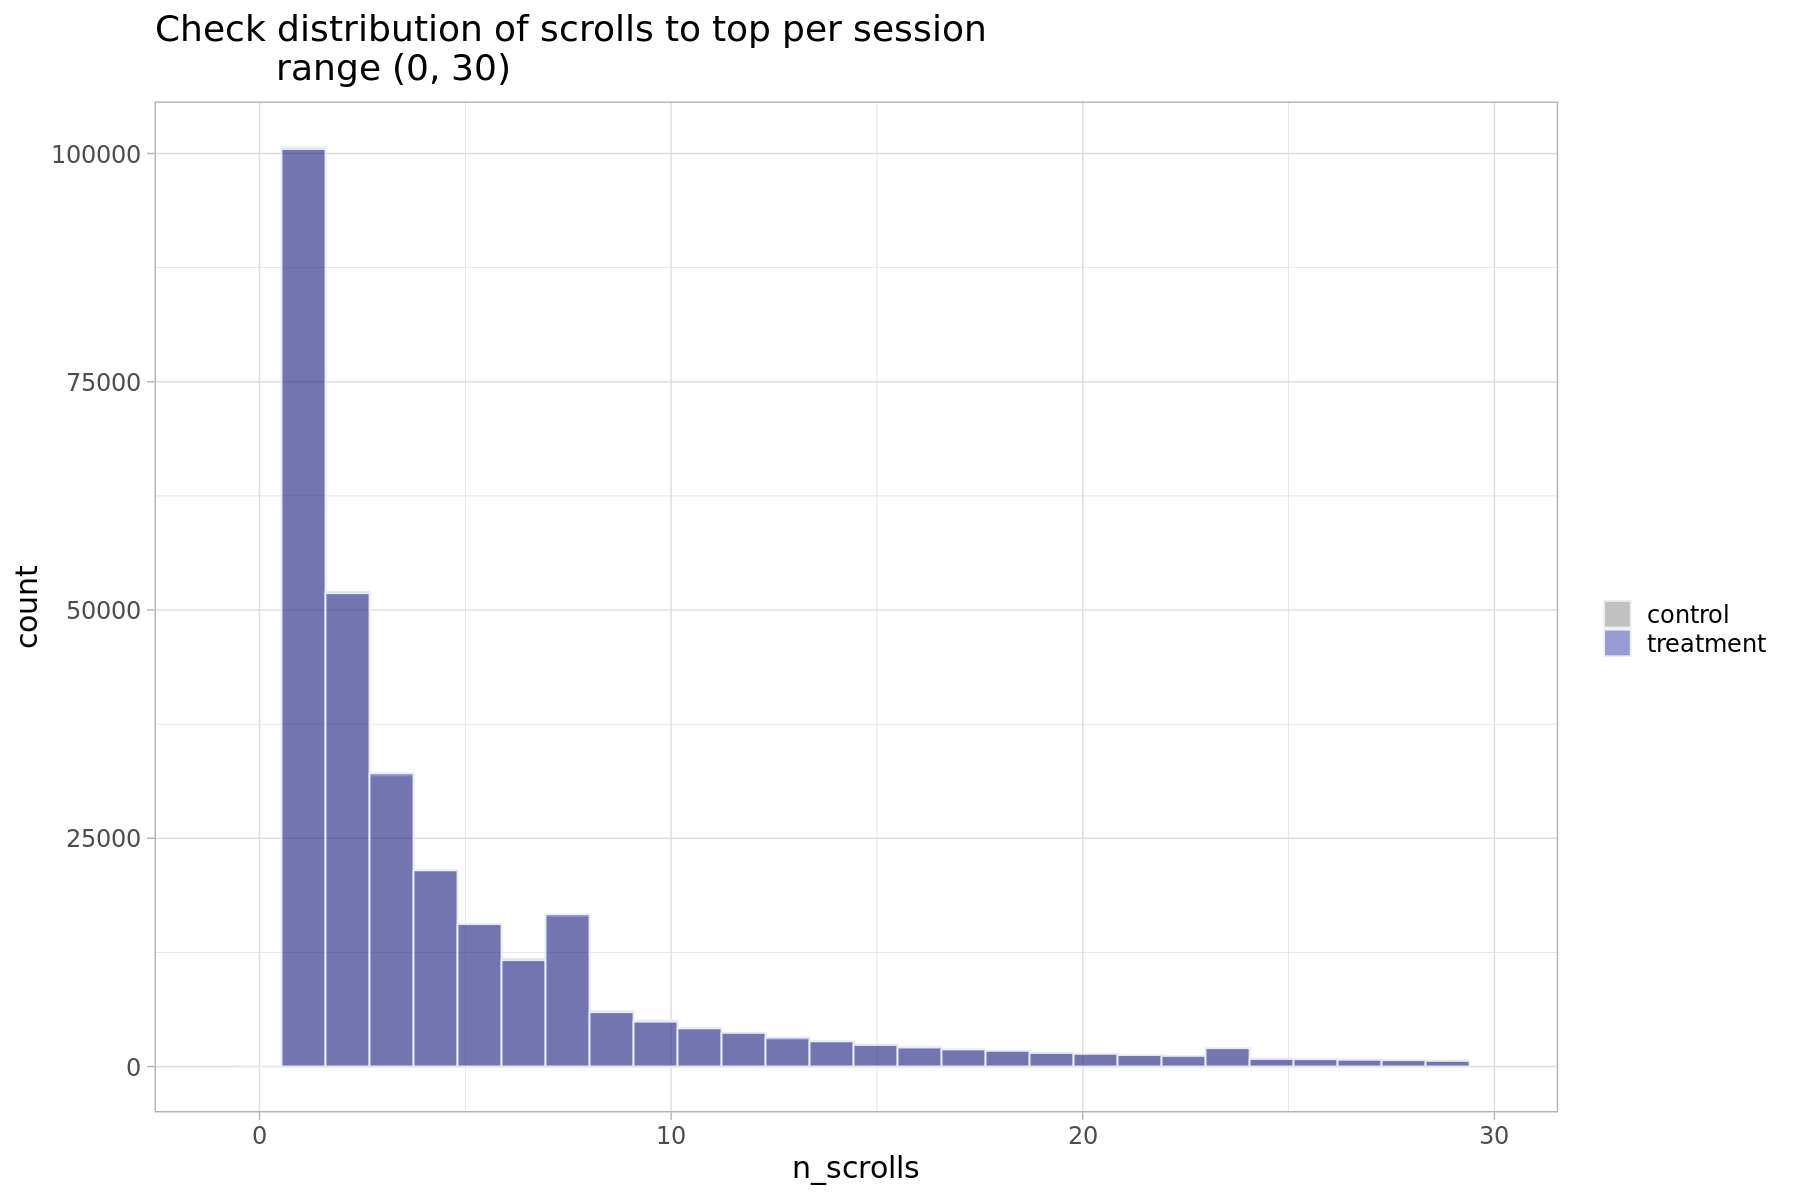

In [45]:
p1 <- df_scroll_pv  %>%
  filter(n_scrolls>0) %>%
  ggplot( aes(x=n_scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of scrolls to top per session
           range (0, 30) ",
         fill="") +
    theme_light(base_size=18)
p1

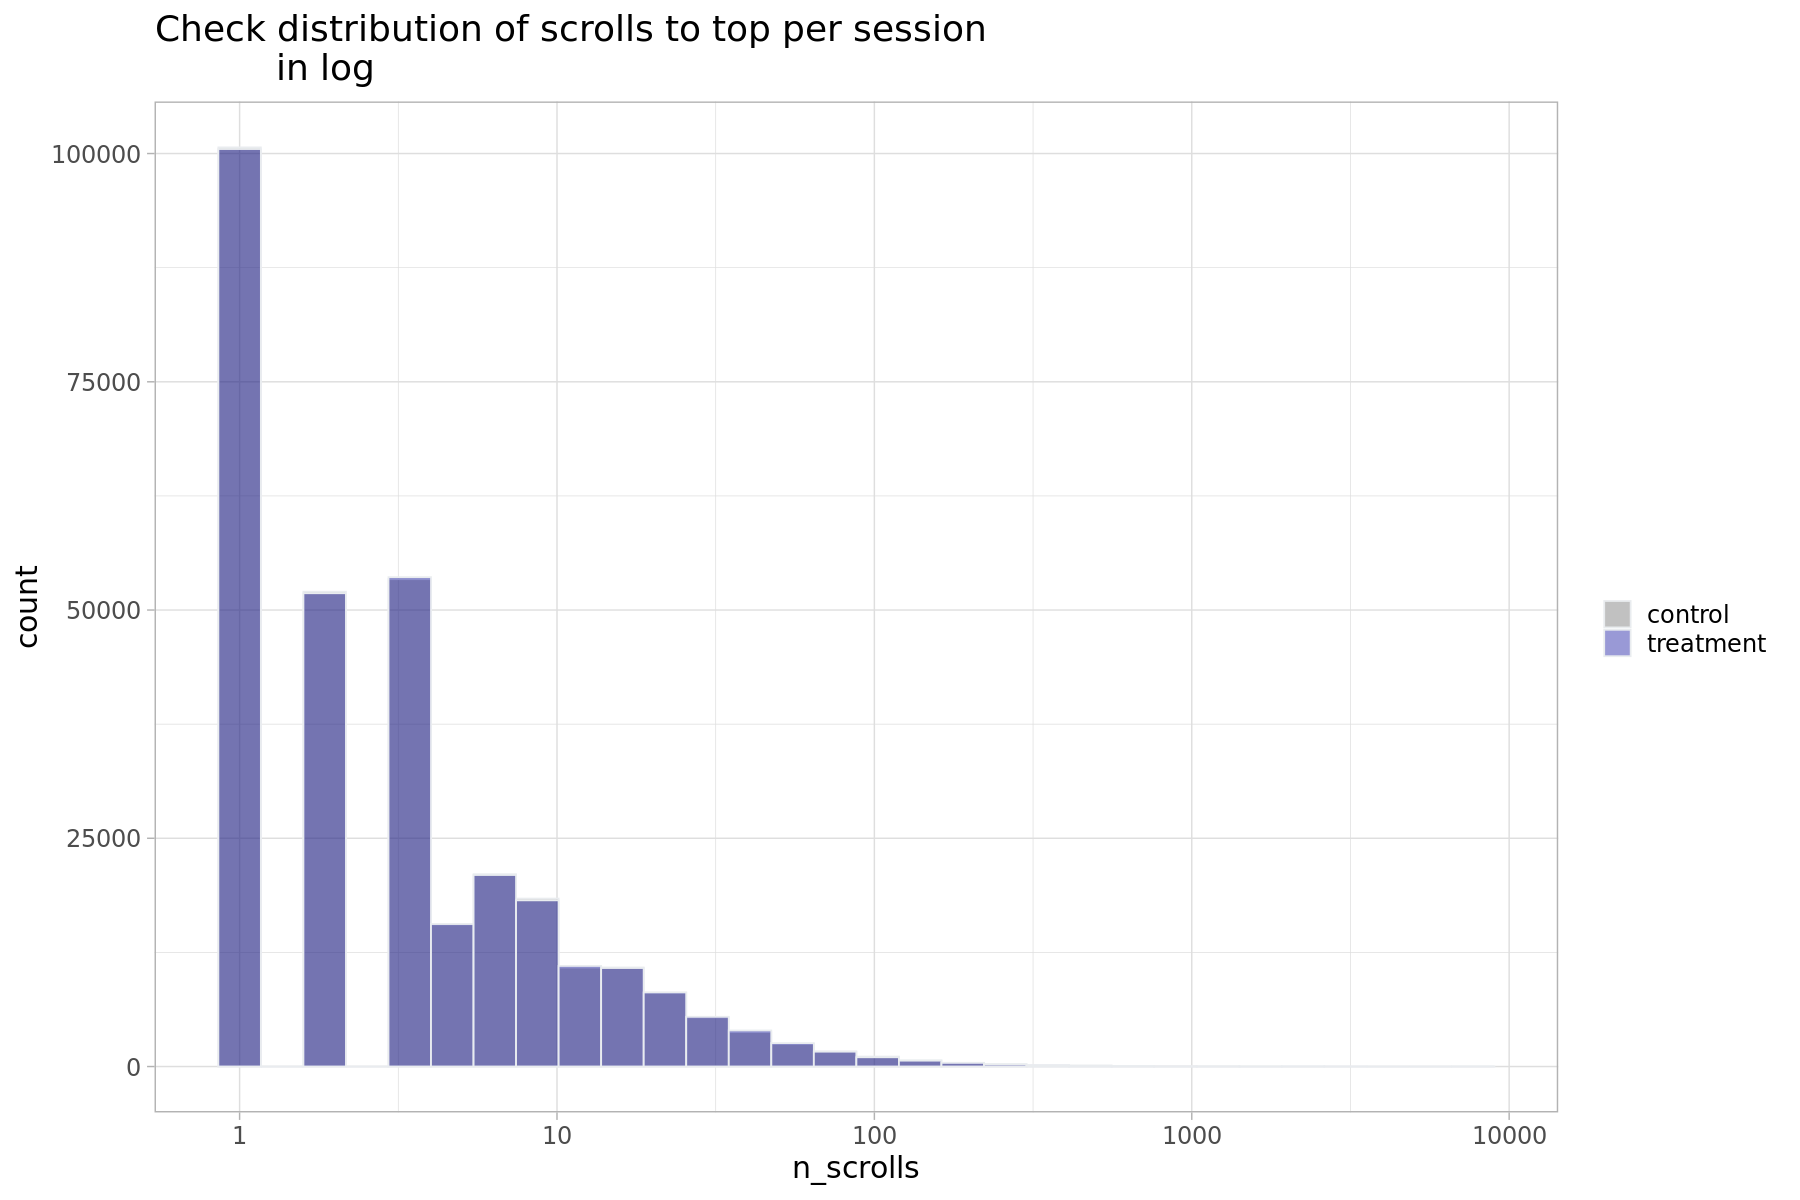

In [46]:
p2 <- df_scroll_pv  %>%
  filter(n_scrolls>0) %>%
  ggplot( aes(x=n_scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of scrolls to top per session
           in log ",
         fill="") +
    theme_light(base_size=18)
p2

In [49]:
cor(df_scroll_pv$n_scrolls, df_scroll_pv$total_pvs)

[1] 0.7594186

In [50]:
cor(df_scroll_pv$n_s_pages, df_scroll_pv$total_pvs)

[1] 0.7809486

In [51]:
cor(df_scroll_pv$n_scrolls, df_scroll_pv$n_s_pages)

[1] 0.8943753

In [53]:
cor(df_scroll_pv$total_pvs, df_scroll_pv$total_pv_pages)

[1] 0.9999996

In [54]:
cor(df_scroll_pv$n_s_pages, df_scroll_pv$total_pv_pages)

[1] 0.7809268

# Analysis
## By wiki

In [56]:
df_wiki <- df_scroll_pv %>%
  group_by(wiki, test_group) %>%
  summarize(cnt_session_init=n_distinct(session_id), sum_pvs=sum(total_pvs), sum_pv_pages=sum(total_pv_pages), sum_scrolls=sum(n_scrolls), sum_s_pages=sum(n_s_pages),.groups='drop')

In [58]:
df_wiki <- df_wiki %>%
      mutate( scrolls_per_page =round(sum_scrolls/sum_s_pages,2)
          )

In [59]:
df_wiki

wiki,test_group,cnt_session_init,sum_pvs,sum_pv_pages,sum_scrolls,sum_s_pages,scrolls_per_page
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
enwiki,control,451785,8032826,8031653,1863083,1089715,1.71
enwiki,treatment,422227,7975065,7974056,1859806,1091977,1.70
fawiki,control,9573,156055,155993,41721,20982,1.99
fawiki,treatment,8954,125034,125000,35521,17909,1.98
frwiki,control,55295,953480,953377,222408,121592,1.83
frwiki,treatment,52465,925160,925046,216491,120464,1.80
hewiki,control,9136,188825,188803,47255,25724,1.84
hewiki,treatment,9777,195126,195085,48346,25654,1.88
kowiki,control,4728,98851,98850,16117,7686,2.10


In [62]:
df_wiki %>% 
  group_by(test_group) %>%
  summarize( all_sessions=sum(cnt_session_init), all_pvs=sum(sum_pvs), all_pv_pages=sum(sum_pv_pages), all_scrolls=sum(sum_scrolls), 
            all_scrolled_pages=sum(sum_s_pages), .groups='drop' ) %>%
   mutate( scrolls_per_page =round(all_scrolls/all_scrolled_pages,2))

test_group,all_sessions,all_pvs,all_pv_pages,all_scrolls,all_scrolled_pages,scrolls_per_page
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
control,569972,10056089,10054632,2328970,1338768,1.74
treatment,536839,9868007,9866735,2309449,1334575,1.73


### Note

We observed that the number of scrolls to top is same in treatment group and control group overall

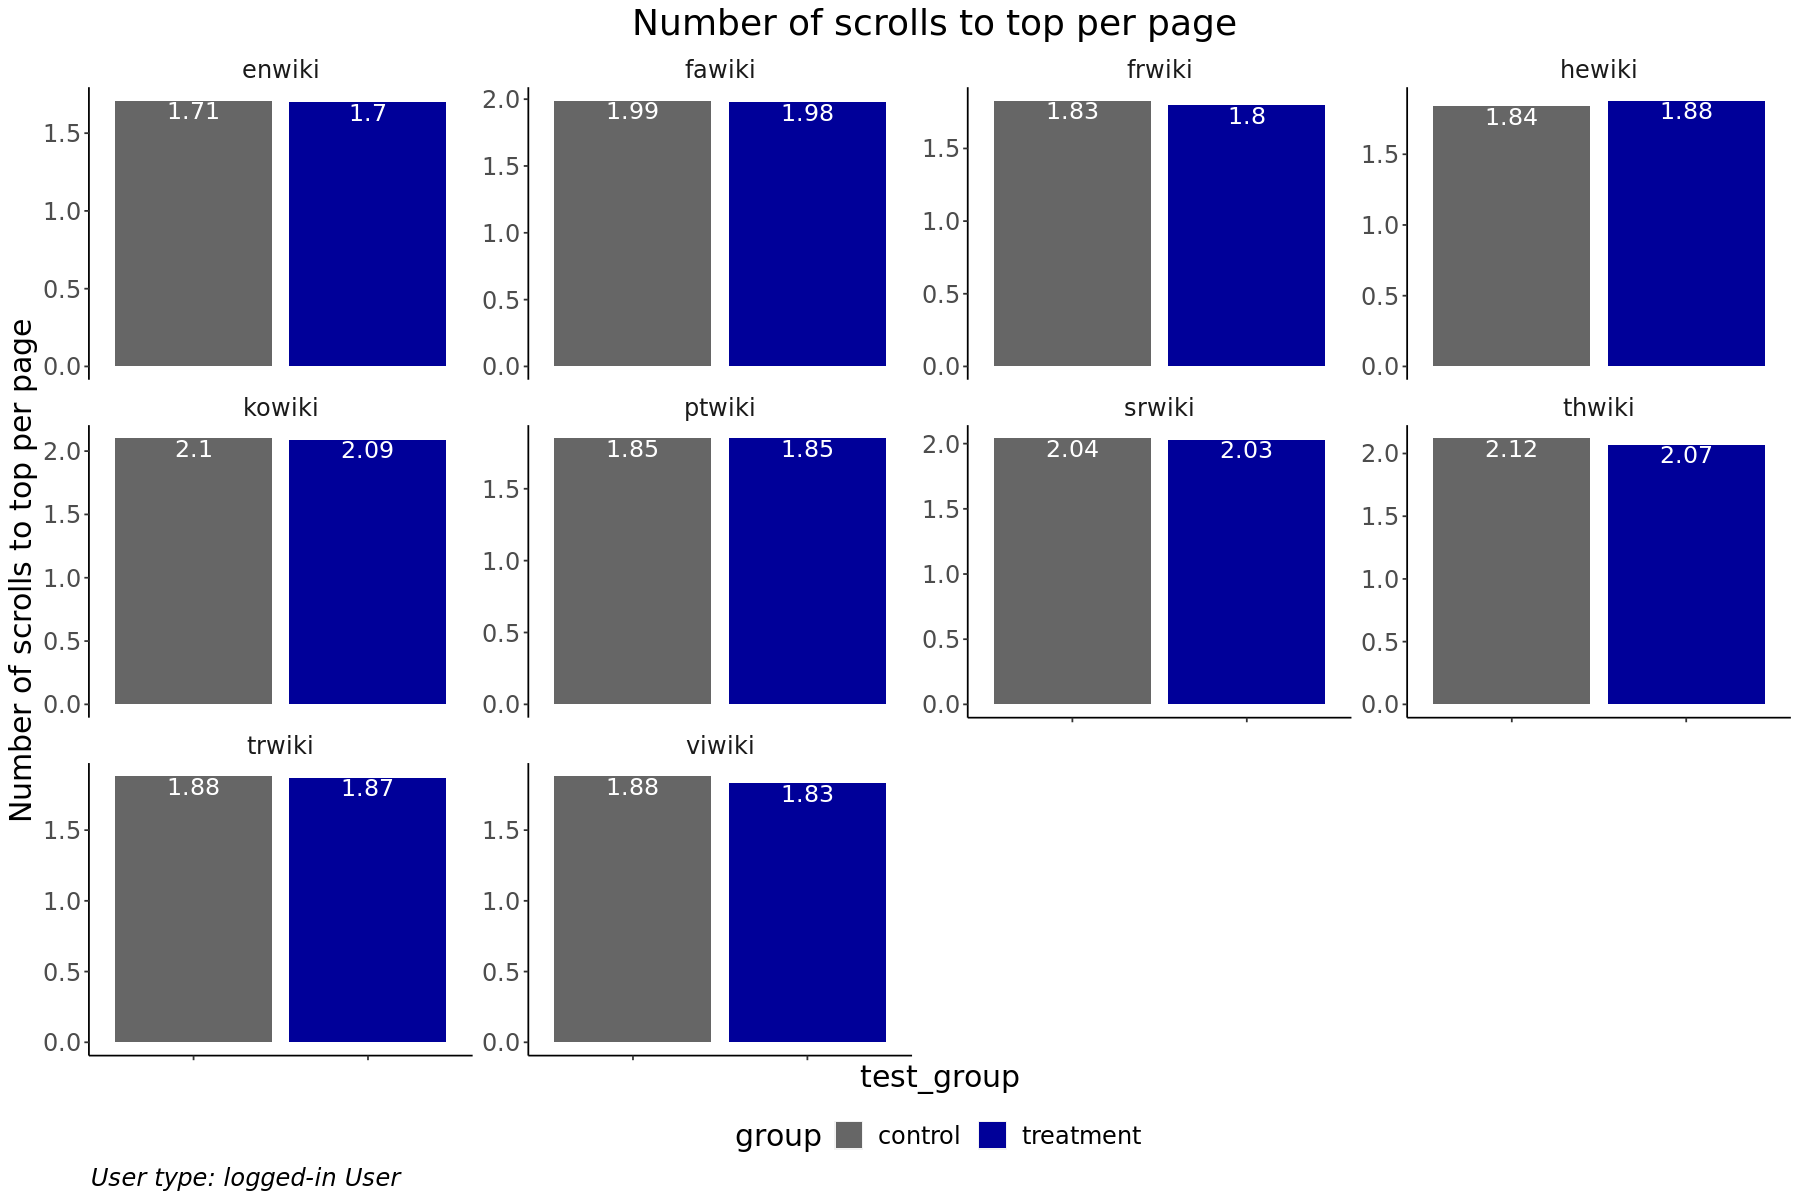

In [76]:
barchart_scrolls_per_page  <- df_wiki  %>%
        select(wiki, test_group, scrolls_per_page) %>%
        ggplot(aes(x = test_group, y= scrolls_per_page, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(scrolls_per_page)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls to top per page" ,
             title = "Number of scrolls to top per page " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scrolls_per_page

### Note
We did not observed a significant difference in the number of scrolls to top between the control and treatment groups across wikis.

## By edit count bucket

In [68]:
df_scroll_editbucket_overall <-       df_scroll_pv %>%
  group_by(editcountbucket_lab, test_group) %>%
  summarize(cnt_session_init=n_distinct(session_id), sum_pvs=sum(total_pvs), sum_pv_pages=sum(total_pv_pages), sum_scrolls=sum(n_scrolls), sum_s_pages=sum(n_s_pages),.groups='drop') %>%
   mutate( scrolls_per_page =round(sum_scrolls/sum_s_pages,2))

In [69]:
df_scroll_editbucket_overall 

editcountbucket_lab,test_group,cnt_session_init,sum_pvs,sum_pv_pages,sum_scrolls,sum_s_pages,scrolls_per_page
<fct>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0_edits,control,186627,1675249,1674933,405837,239268,1.70
0_edits,treatment,153733,1551263,1550968,395721,233737,1.69
1_4_edits,control,74938,828957,828788,216254,134873,1.60
1_4_edits,treatment,73213,822927,822811,220600,135944,1.62
5_99_edits,control,150087,2253880,2253578,576193,355100,1.62
5_99_edits,treatment,152687,2207717,2207439,574274,352968,1.63
100_999_edits,control,77818,1686450,1686178,407014,242726,1.68
100_999_edits,treatment,80104,1750183,1749961,430785,253494,1.70
1000_more_edits,control,80502,3611553,3611155,723672,366801,1.97


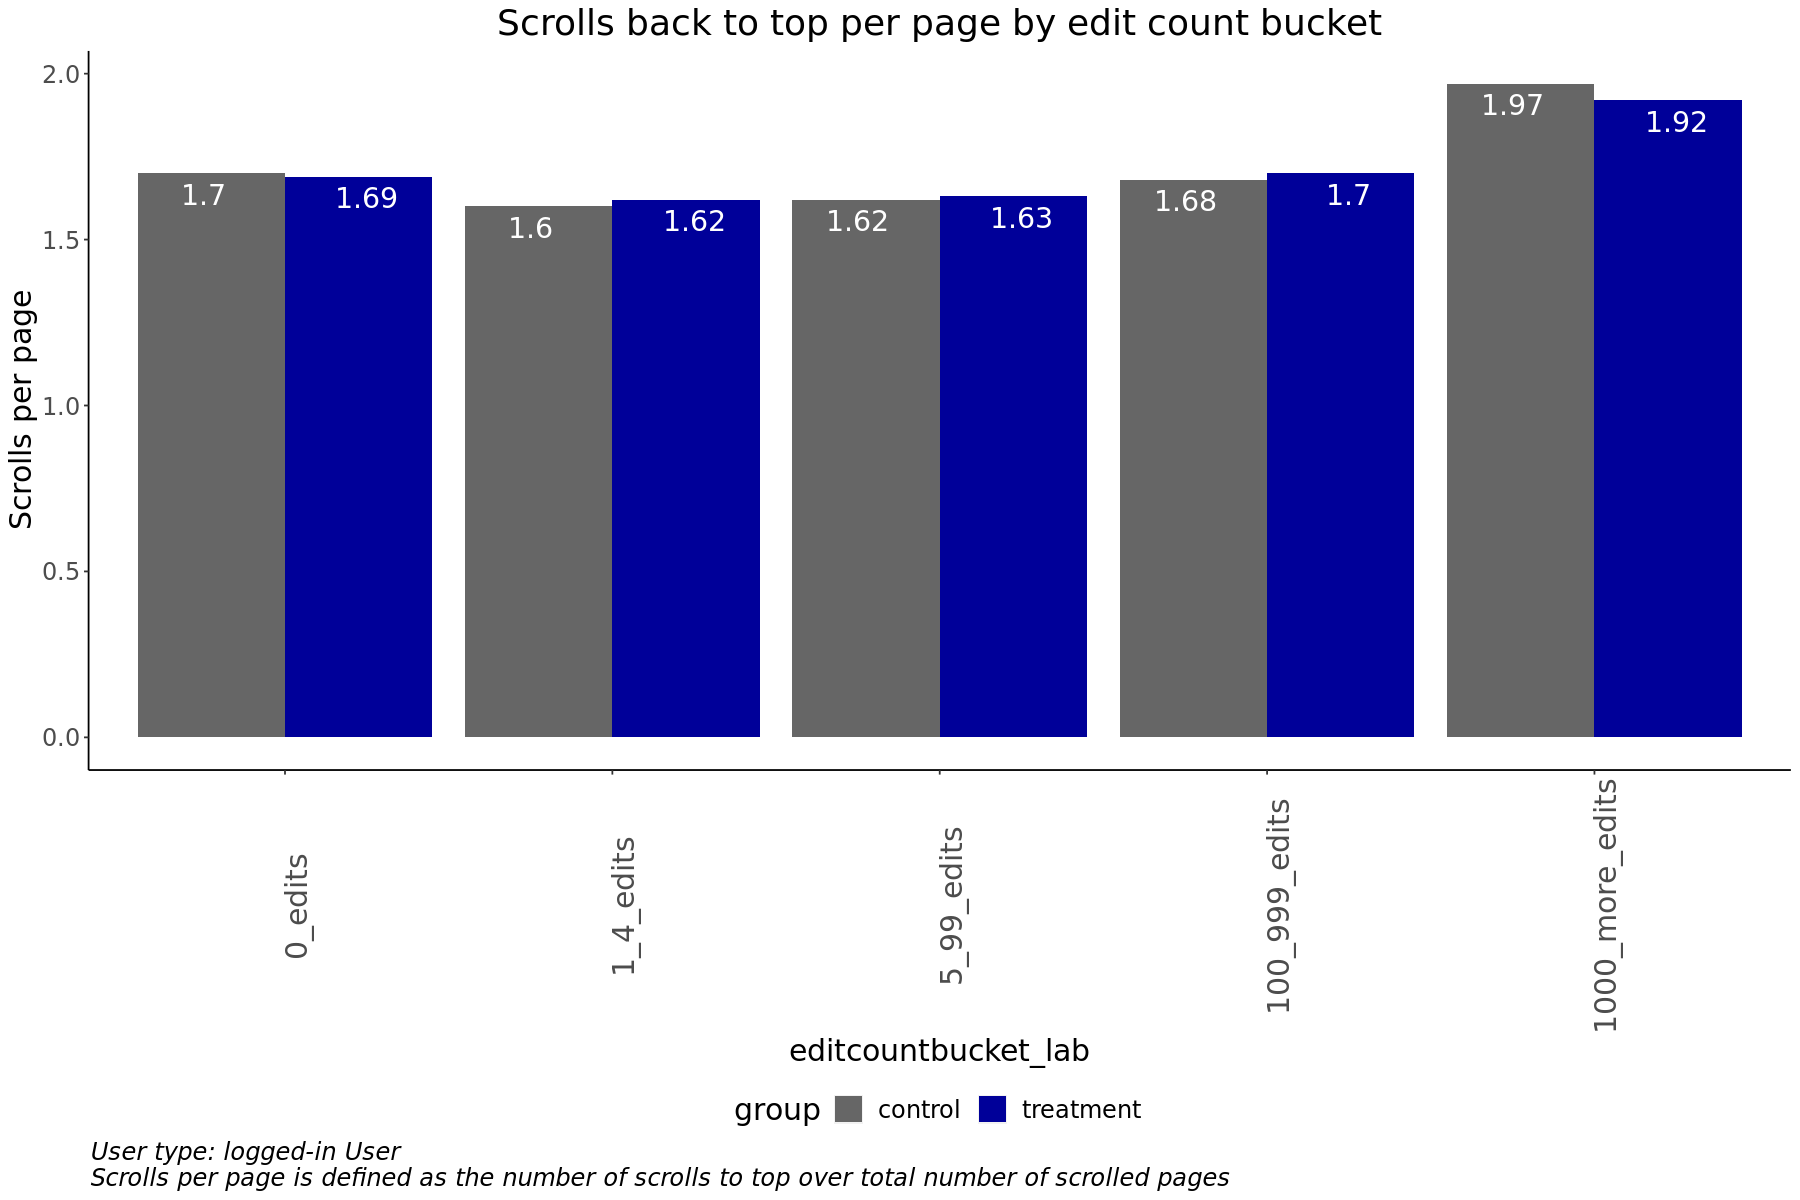

In [74]:
barchart_scroll_editcountbucket_overall  <- df_scroll_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= scrolls_per_page, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(scrolls_per_page)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.5, hjust = 0.5, size = 6) +
        labs (
              y = "Scrolls per page" ,
             title = "Scrolls back to top per page by edit count bucket" ,
             caption = "User type: logged-in User
Scrolls per page is defined as the number of scrolls to top over total number of scrolled pages" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scroll_editcountbucket_overall

### Note

We did not observered a significant difference in the number of scrolls to top between the control and treatment groups across edit count buckets.